In [1]:
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Disable GPU, force CPU

In [3]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))

2025-08-03 12:05:06.457778: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754222706.476041    5814 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754222706.481624    5814 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0
GPUs: []


2025-08-03 12:05:09.412592: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-08-03 12:05:09.412769: E external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:262] kernel version 550.163.1 does not match DSO version 560.35.5 -- cannot find working devices in this configuration


In [4]:
!pip install pretty_midi pygame imbalanced-learn seaborn

In [5]:
# importing all necessary libraries
import numpy as np
np.int = int 
import zipfile
import io
import pretty_midi
import pkg_resources
import os
import warnings
import pandas as pd 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import tempfile
import pygame
import math
from tqdm import tqdm

# tensorflow libraries
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dropout, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

/opt/conda/lib/python3.12/site-packages/pretty_midi/instrument.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


pygame 2.6.1 (SDL 2.28.4, Python 3.12.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [6]:
import warnings

# Suppress pretty_midi runtime warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Suppress deprecation warning for pkg_resources
warnings.filterwarnings("ignore", message="pkg_resources is deprecated as an API.")

# Suppress np.int deprecation warning
warnings.filterwarnings("ignore", category=DeprecationWarning, message=r"`np\.int` is a deprecated alias for the builtin `int`")

### Data loading and preparation

In [7]:
import os
import pretty_midi
import pandas as pd
from tqdm import tqdm

# Configuration
MIDI_FOLDER = 'selectedcomposers'  # path to your root folder
COMPOSERS = ['Bach', 'Beethoven', 'Chopin', 'Mozart']
composer_to_label = {c: i for i, c in enumerate(COMPOSERS)}

# Storage
note_features = []

In [8]:
def extract_note_features(midi, composer, composer_id, chunk_size=300):
    features = []

    # Extract global tempo
    try:
        tempo = midi.estimate_tempo()
    except:
        tempo = 120.0  # fallback tempo

    for instrument in midi.instruments:
        if instrument.is_drum:
            continue
        instrument_program = instrument.program
        notes = sorted(instrument.notes, key=lambda n: n.start)

        if len(notes) < chunk_size:
            continue  # skip short instruments

        # Chunk the notes (non-overlapping)
        for i in range(0, len(notes) - chunk_size + 1, chunk_size):
            chunk = notes[i:i+chunk_size]
            chunk_start = chunk[0].start
            chunk_end = chunk[-1].end
            chunk_duration = chunk_end - chunk_start

            # ---- Higher-level stats ----
            pitches = [n.pitch for n in chunk]
            durations = [n.end - n.start for n in chunk]
            velocities = [n.velocity for n in chunk]
            intervals = [pitches[i] - pitches[i-1] for i in range(1, len(pitches))]
            starts = [n.start for n in chunk]

            pitch_range = max(pitches) - min(pitches)
            note_density = len(chunk) / (chunk_duration + 1e-6)  # notes/sec
            repetition_rate = sum([1 for i in range(1, len(pitches)) if pitches[i] == pitches[i-1]]) / len(pitches)
            avg_interval = np.mean(intervals) if intervals else 0.0
            rhythmic_variety = np.std(durations)
            chord_density = sum([1 for i in range(1, len(chunk)) if chunk[i].start < chunk[i-1].end]) / len(chunk)

            # ---- Per-note features ----
            prev_start = chunk[0].start
            prev_pitch = chunk[0].pitch

            for note in chunk:
                pitch = note.pitch
                start = note.start
                end = note.end
                duration = end - start
                delta_time = start - prev_start
                velocity = note.velocity
                interval = pitch - prev_pitch
                is_accented = 1 if velocity > 80 else 0

                features.append({
                    "Pitch": pitch,
                    "Duration": duration,
                    "Velocity": velocity,
                    "DeltaTime": delta_time,
                    "Start": start,
                    "End": end,
                    "Interval": interval,
                    "Program": instrument_program,
                    "Accented": is_accented,
                    "Composer": composer,
                    "ComposerID": composer_id,
                    "Tempo": tempo,
                    "PitchRange": pitch_range,
                    "NoteDensity": note_density,
                    "RepetitionRate": repetition_rate,
                    "AvgInterval": avg_interval,
                    "RhythmicVariety": rhythmic_variety,
                    "ChordDensity": chord_density
                })

                prev_start = start
                prev_pitch = pitch

    return features

In [9]:
# Iterate over all MIDI files for all composers
for composer in COMPOSERS:
    composer_path = os.path.join(MIDI_FOLDER, composer)
    composer_id = composer_to_label[composer]
    for file in tqdm(os.listdir(composer_path), desc=f"Processing {composer}"):
        if not file.endswith('.mid'):
            continue
        filepath = os.path.join(composer_path, file)
        try:
            midi = pretty_midi.PrettyMIDI(filepath)
            note_features.extend(extract_note_features(midi, composer, composer_id))
        except Exception as e:
            print(f"Error processing {filepath}: {e}")

Processing Beethoven:  92%|█████████▏| 131/143 [00:18<00:00, 13.34it/s]

Error processing selectedcomposers/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255


Processing Mozart: 100%|██████████| 95/95 [00:09<00:00, 10.17it/s]


Processing Mozart: 100%|██████████| 94/94 [00:03<00:00, 28.28it/s]


In [10]:
df_notes = pd.DataFrame(note_features)
print(df_notes.head())
print(df_notes['Composer'].value_counts())

   Pitch  Duration  Velocity  DeltaTime   Start     End  Interval  Program  \
0     72    0.1875       100     0.0000  0.3750  0.5625         0       24   
1     74    0.1875       100     0.1875  0.5625  0.7500         2       24   
2     75    0.3750       100     0.1875  0.7500  1.1250         1       24   
3     79    0.3750       100     0.3750  1.1250  1.5000         4       24   
4     83    0.3750       100     0.3750  1.5000  1.8750         4       24   

   Accented Composer  ComposerID       Tempo  PitchRange  NoteDensity  \
0         1     Bach           0  160.264901          25     4.102564   
1         1     Bach           0  160.264901          25     4.102564   
2         1     Bach           0  160.264901          25     4.102564   
3         1     Bach           0  160.264901          25     4.102564   
4         1     Bach           0  160.264901          25     4.102564   

   RepetitionRate  AvgInterval  RhythmicVariety  ChordDensity  
0        0.023333     0.0401

In [11]:
print(df_notes.tail())

         Pitch  Duration  Velocity  DeltaTime       Start         End  \
1388095     31  0.163866        72   0.252101  191.147863  191.311729   
1388096     31  0.077586       105   1.402856  192.550719  192.628305   
1388097     35  0.077586       105   0.129310  192.680029  192.757615   
1388098     38  0.077586       105   0.129311  192.809340  192.886926   
1388099     41  0.155173       105   0.129311  192.938650  193.093823   

         Interval  Program  Accented Composer  ComposerID       Tempo  \
1388095       -12       43         0   Mozart           3  238.558316   
1388096         0       43         1   Mozart           3  238.558316   
1388097         4       43         1   Mozart           3  238.558316   
1388098         3       43         1   Mozart           3  238.558316   
1388099         3       43         1   Mozart           3  238.558316   

         PitchRange  NoteDensity  RepetitionRate  AvgInterval  \
1388095          20     3.073996            0.48    -0.01

In [12]:
df_notes.shape

(1388100, 18)

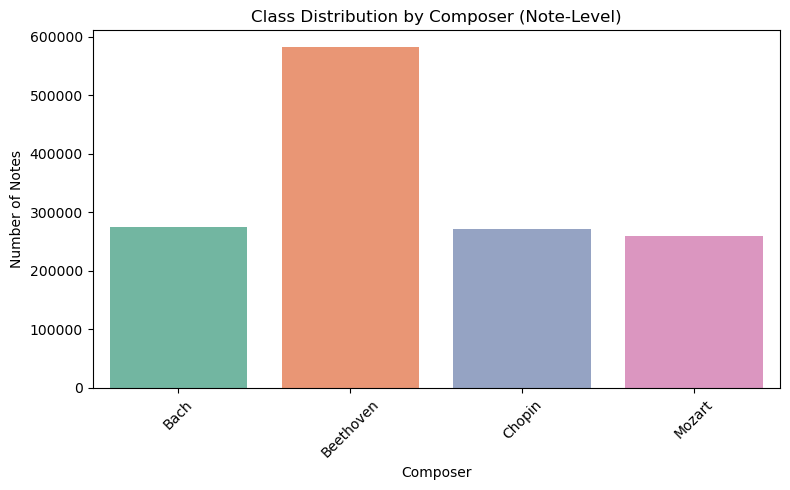

In [13]:
# Count notes per composer
class_counts = df_notes['Composer'].value_counts().sort_index()

# Plot without warning
plt.figure(figsize=(8, 5))
sns.barplot(x=class_counts.index, y=class_counts.values, hue=class_counts.index, palette='Set2', legend=False)
plt.title("Class Distribution by Composer (Note-Level)")
plt.xlabel("Composer")
plt.ylabel("Number of Notes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Train, Val and test split 

In [14]:
def split_by_composer_temporally(df, train_frac=0.7, val_frac=0.15, test_frac=0.15):
    assert np.isclose(train_frac + val_frac + test_frac, 1.0), "Fractions must sum to 1"

    train_dfs, val_dfs, test_dfs = [], [], []

    for composer in df['Composer'].unique():
        df_c = df[df['Composer'] == composer].sort_values(by='Start')  # keep temporal order
        n = len(df_c)

        train_end = int(n * train_frac)
        val_end = int(n * (train_frac + val_frac))

        df_train = df_c.iloc[:train_end]
        df_val = df_c.iloc[train_end:val_end]
        df_test = df_c.iloc[val_end:]

        train_dfs.append(df_train)
        val_dfs.append(df_val)
        test_dfs.append(df_test)

    df_train = pd.concat(train_dfs).reset_index(drop=True)
    df_val = pd.concat(val_dfs).reset_index(drop=True)
    df_test = pd.concat(test_dfs).reset_index(drop=True)

    return df_train, df_val, df_test

# Call the split function
df_train, df_val, df_test = split_by_composer_temporally(df_notes)

# Show class balance
print("Train distribution:\n", df_train['Composer'].value_counts())
print("Val distribution:\n", df_val['Composer'].value_counts())
print("Test distribution:\n", df_test['Composer'].value_counts())

Train distribution:
 Composer
Beethoven    407400
Bach         192360
Chopin       189840
Mozart       182070
Name: count, dtype: int64
Val distribution:
 Composer
Beethoven    87300
Bach         41220
Chopin       40680
Mozart       39015
Name: count, dtype: int64
Test distribution:
 Composer
Beethoven    87300
Bach         41220
Chopin       40680
Mozart       39015
Name: count, dtype: int64


*	Each composer’s notes are sorted by start time and split chronologically.
*	This ensures that:
*	LSTM sees past --> future during training.
*	Validation/test sets contain unseen future chunks.
*	You now have clean df_train, df_val, and df_test DataFrames.

### Data Preprocessing - perform Note-Level Data Augmentation (on df_train only)

In [15]:
# Get class counts
train_counts = df_train['Composer'].value_counts()
target_count = train_counts.max()

# Define augmentation function (on a group of notes)
def augment_notes(notes_df):
    df_aug = notes_df.copy()

    # Random parameters
    pitch_shift = np.random.choice([-3, -2, -1, 1, 2, 3])
    duration_scale = np.random.uniform(0.9, 1.1)
    time_shift = np.random.uniform(-0.1, 0.1)

    df_aug['Pitch'] = np.clip(df_aug['Pitch'] + pitch_shift, 0, 127)
    df_aug['Duration'] = df_aug['Duration'] * duration_scale
    df_aug['Start'] = df_aug['Start'] + time_shift
    df_aug['End'] = df_aug['Start'] + df_aug['Duration']
    
    return df_aug


In [20]:
# Apply augment_notes to balance training data
from sklearn.utils import resample

# 1. Prepare
chunk_size = 100
augmented_dfs = []

# 2. Loop through each composer
for composer in df_train['Composer'].unique():
    df_c = df_train[df_train['Composer'] == composer]
    current_count = len(df_c)
    if current_count >= target_count:
        continue  # Skip augmentation for already majority class

    needed = target_count - current_count
    num_chunks_needed = needed // chunk_size

    # Chunk the composer data into fixed-size groups
    note_chunks = [df_c.iloc[i:i+chunk_size] for i in range(0, len(df_c)-chunk_size, chunk_size)]

    # 3. Augment by sampling and modifying chunks
    for _ in range(num_chunks_needed):
        chunk = resample(note_chunks, n_samples=1, replace=True)[0]
        augmented = augment_notes(chunk)
        augmented['Source'] = 'Augmented'
        augmented_dfs.append(augmented)

# 4. Combine original + augmented
df_train['Source'] = 'Original'
df_train_balanced = pd.concat([df_train] + augmented_dfs).reset_index(drop=True)

# 5. Confirm new class balance
print("Balanced Train Distribution:\n", df_train_balanced['Composer'].value_counts())

Balanced Train Distribution:
 Composer
Beethoven    407400
Mozart       407370
Bach         407360
Chopin       407340
Name: count, dtype: int64


comparing pre- vs. post-augmentation visually is an excellent idea to ensure your data augmentation is realistic and effective.

In [21]:
# Combine correctly
df_augmented = pd.concat(augmented_dfs).reset_index(drop=True)
df_train['Source'] = 'Original'
df_compare = pd.concat([df_train, df_augmented]).reset_index(drop=True)

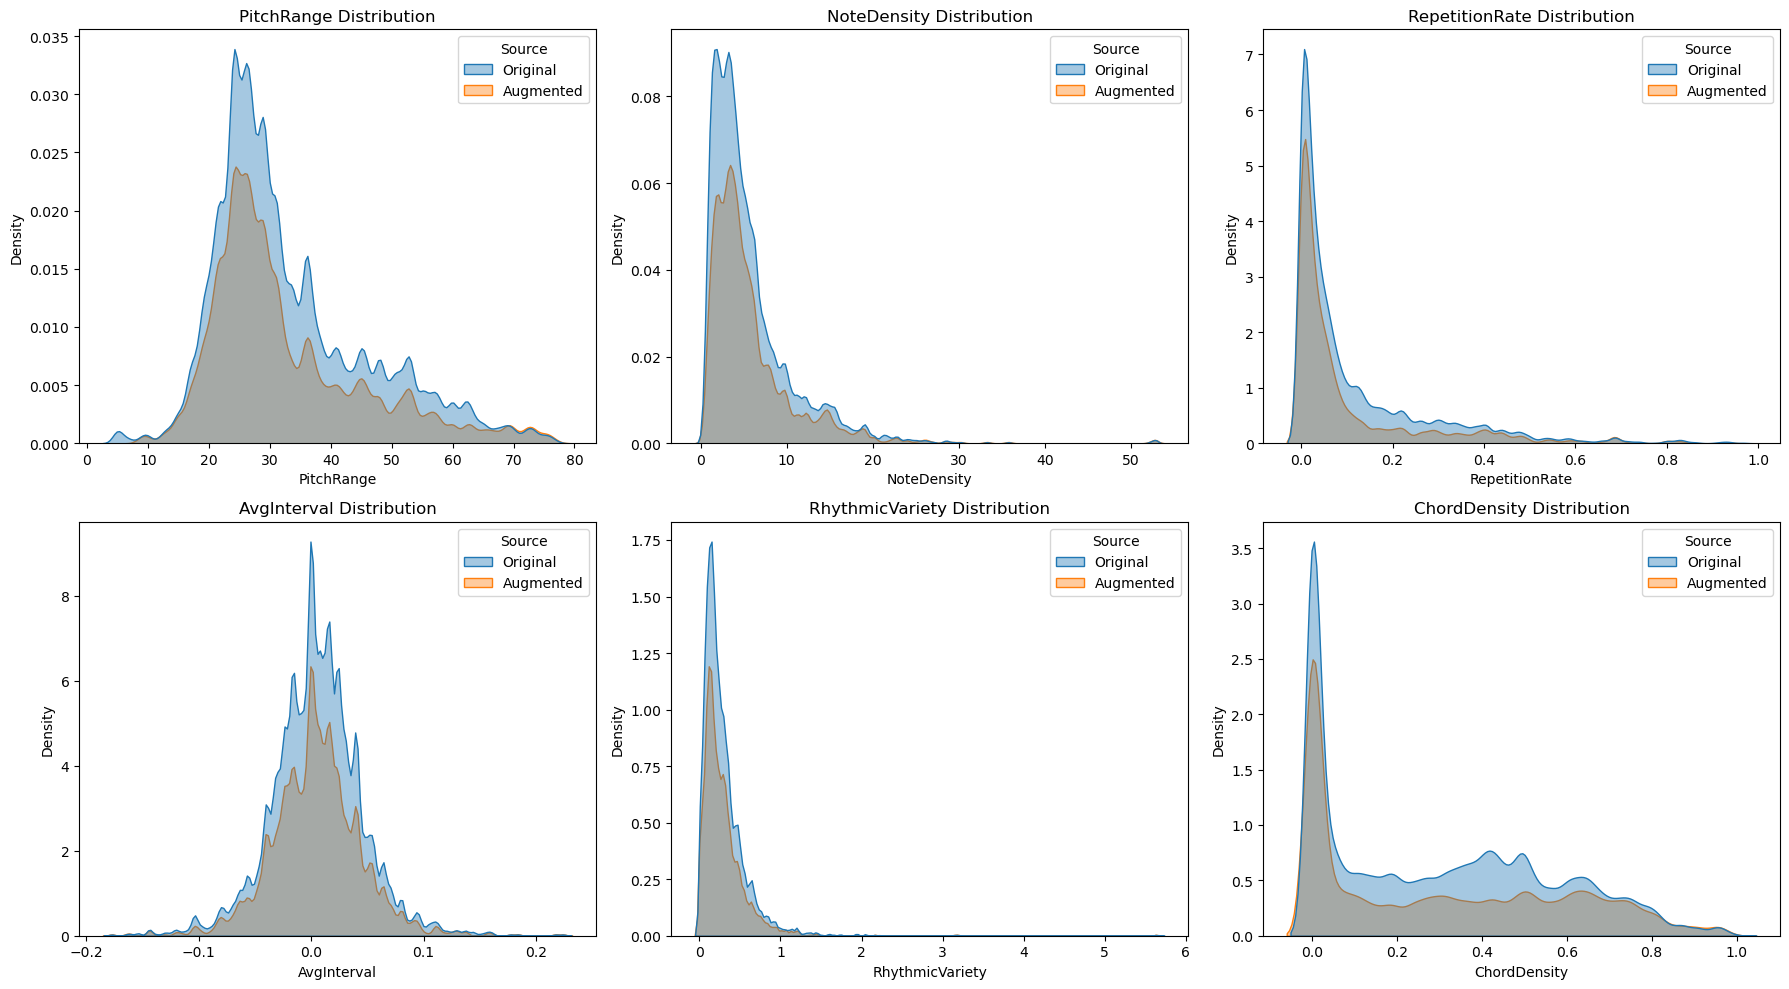

In [22]:
plt.figure(figsize=(18, 10))

features = ['PitchRange', 'NoteDensity', 'RepetitionRate', 'AvgInterval', 'RhythmicVariety', 'ChordDensity']

for i, feat in enumerate(features):
    plt.subplot(2, 3, i + 1)
    sns.kdeplot(data=df_compare, x=feat, hue='Source', fill=True, alpha=0.4)
    plt.title(f'{feat} Distribution')

plt.tight_layout()
plt.show()

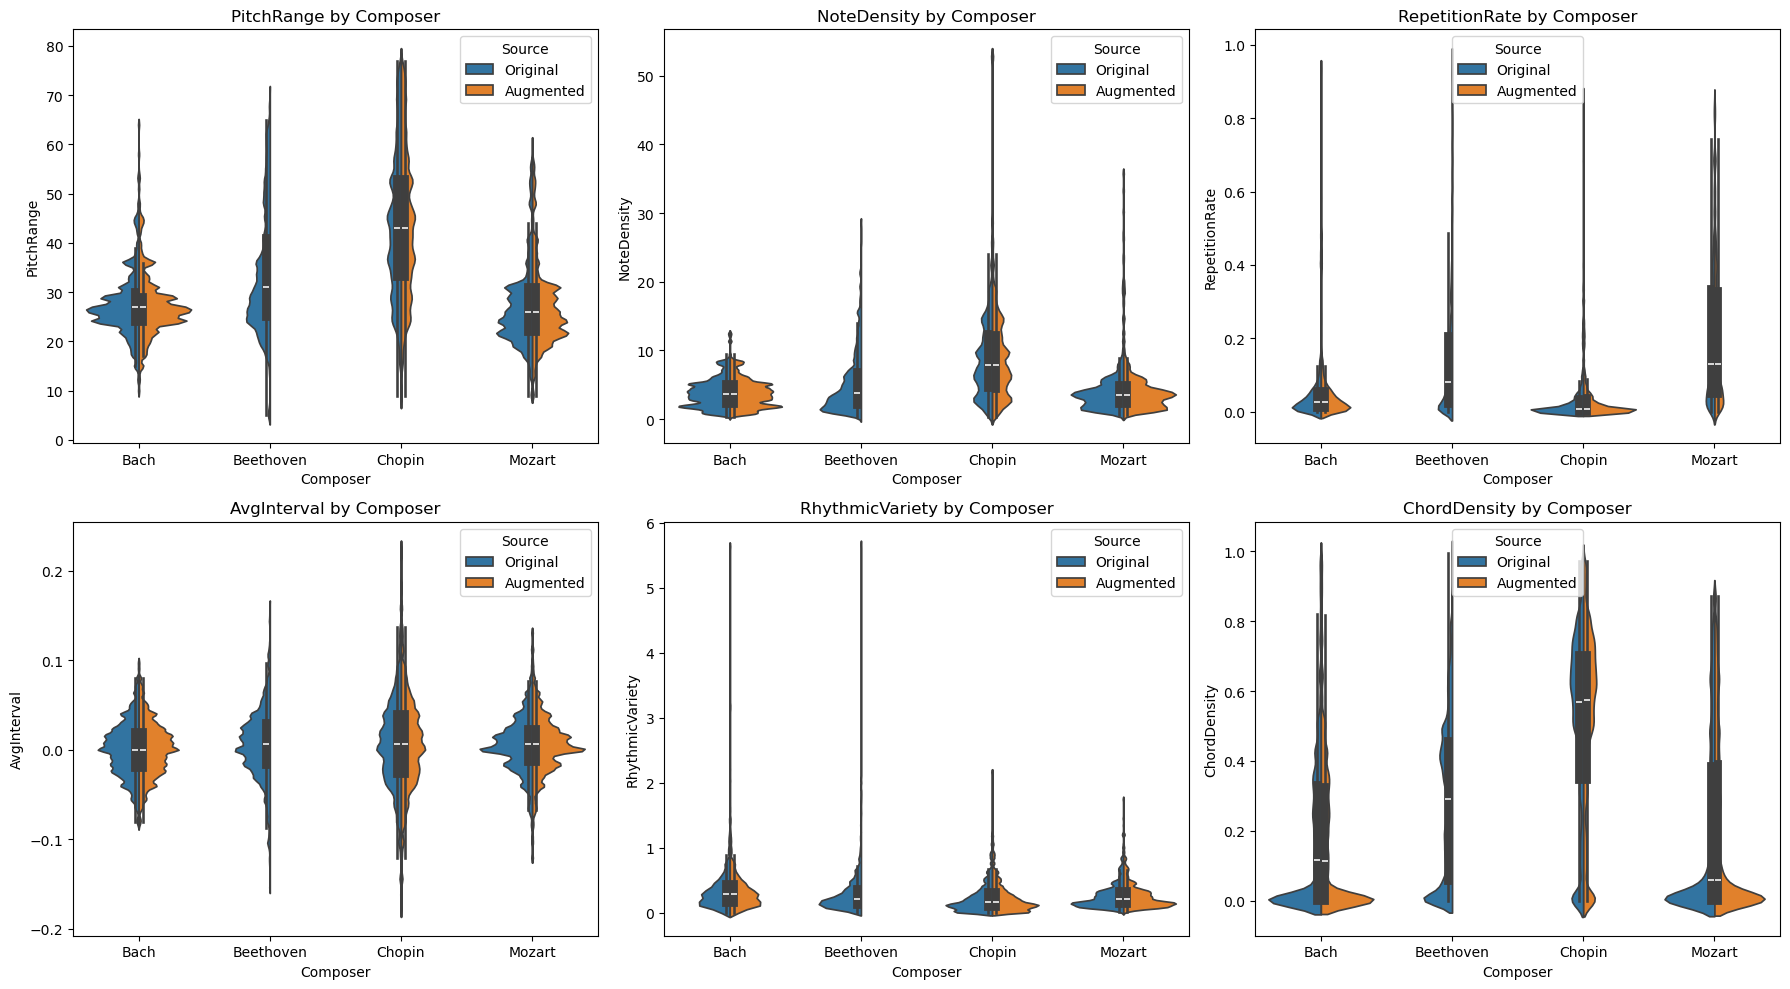

In [23]:
plt.figure(figsize=(18, 10))

features = ['PitchRange', 'NoteDensity', 'RepetitionRate', 'AvgInterval', 'RhythmicVariety', 'ChordDensity']

for i, feat in enumerate(features):
    plt.subplot(2, 3, i + 1)
    sns.violinplot(data=df_compare, x='Composer', y=feat, hue='Source', split=True)
    plt.title(f'{feat} by Composer')

plt.tight_layout()
plt.show()

#### Remove redundant features if any by visualizing correlation matrix

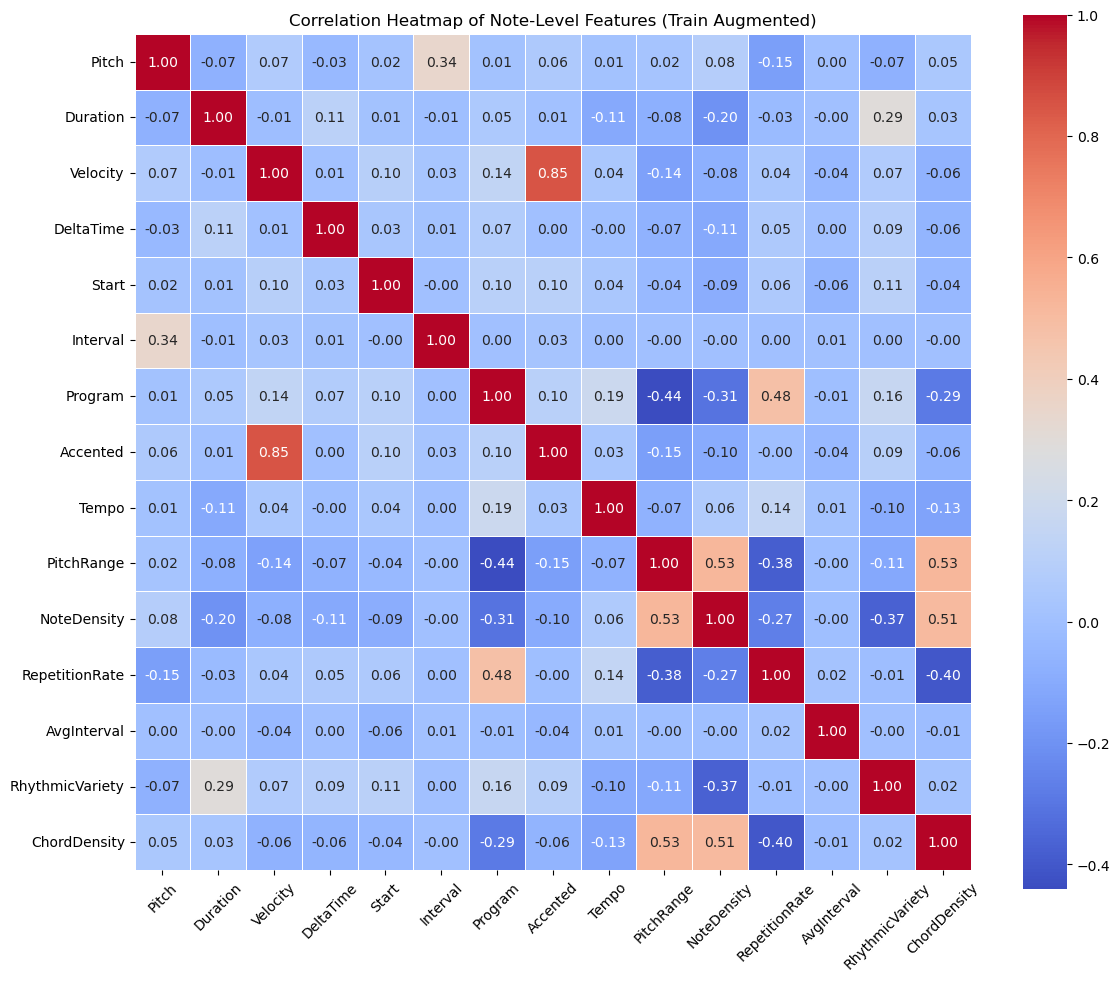

In [24]:

numeric_features = [
    'Pitch', 'Duration', 'Velocity', 'DeltaTime', 'Start', 'Interval', 'Program', 'Accented',
    'Tempo', 'PitchRange', 'NoteDensity', 'RepetitionRate',
    'AvgInterval', 'RhythmicVariety', 'ChordDensity'
]

# Compute correlation matrix
corr_matrix = df_train_balanced[numeric_features].corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, square=True)
plt.title("Correlation Heatmap of Note-Level Features (Train Augmented)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#### perform standardscaling on the train, val and test datasets separately

In [26]:
from sklearn.preprocessing import StandardScaler

# Define features to scale (exclude label columns like 'Composer' or 'ComposerID')
features_to_scale = [
    'Pitch', 'Duration', 'Velocity', 'DeltaTime', 'Start', 'Interval', 'Program', 'Accented',
    'Tempo', 'PitchRange', 'NoteDensity', 'RepetitionRate',
    'AvgInterval', 'RhythmicVariety', 'ChordDensity'
]

# 1. Fit scaler only on train balanced data
scaler = StandardScaler()
df_train_balanced_scaled = df_train_balanced.copy()
df_train_balanced_scaled[features_to_scale] = scaler.fit_transform(df_train_balanced[features_to_scale])

# 2. Apply same scaler to val and test sets
df_val_scaled = df_val.copy()
df_val_scaled[features_to_scale] = scaler.transform(df_val[features_to_scale])

df_test_scaled = df_test.copy()
df_test_scaled[features_to_scale] = scaler.transform(df_test[features_to_scale])

#### Prepare LSTM input sequences

In [27]:
# Define features to use in LSTM input
lstm_features = [
'Pitch', 'Duration', 'Velocity', 'DeltaTime', 'Start', 'Interval', 'Program', 'Accented',
    'Tempo', 'PitchRange', 'NoteDensity', 'RepetitionRate',
    'AvgInterval', 'RhythmicVariety', 'ChordDensity'
]

CHUNK_SIZE = 100  # Number of notes per LSTM input sequence

def create_lstm_chunks(df, chunk_size=CHUNK_SIZE, label_column='ComposerID'):
    X_chunks = []
    y_chunks = []

    # Group by file or composer if available
    grouped = df.groupby(['Composer'])

    for _, group in grouped:
        group = group.sort_values('Start')  # Ensure chronological order
        features = group[lstm_features].values
        labels = group[label_column].values

        # Chunk features and assign label to each chunk
        for i in range(0, len(features) - chunk_size + 1, chunk_size):
            chunk = features[i:i + chunk_size]
            chunk_label = labels[i]  # Take label from first note
            X_chunks.append(chunk)
            y_chunks.append(chunk_label)

    return np.array(X_chunks, dtype=np.float32), np.array(y_chunks, dtype=np.int64)

# Apply to train, val, test
X_train, y_train = create_lstm_chunks(df_train_balanced_scaled)
X_val, y_val     = create_lstm_chunks(df_val_scaled)
X_test, y_test   = create_lstm_chunks(df_test_scaled)

# Final shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (16293, 100, 15)
y_train shape: (16293,)
X_val shape: (2081, 100, 15)
y_val shape: (2081,)
X_test shape: (2081, 100, 15)
y_test shape: (2081,)


#### Define a Function to Build the LSTM Model

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

def build_lstm_model(units=64, dropout_rate=0.5, learning_rate=0.001, input_shape=(100, 15), num_classes=4):
    model = Sequential()
    model.add(Input(shape=input_shape))          # Explicit input layer to avoid warning
    model.add(LSTM(units))                       # No input_shape here
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

#### Perform Grid search on different combinations of parameters

In [32]:
# Define parameter grid
param_grid = {
    'units': [64, 128],
    'dropout_rate': [0.3, 0.5],
    'learning_rate': [0.001, 0.0005],
    'batch_size': [64, 128],
    'epochs': [20]
}

In [33]:
from tensorflow.keras.callbacks import EarlyStopping
import itertools

results = []

for units, dropout_rate, lr, batch_size, epochs in itertools.product(
    param_grid['units'], param_grid['dropout_rate'], 
    param_grid['learning_rate'], param_grid['batch_size'], 
    param_grid['epochs']
):
    print(f"Training model with units={units}, dropout={dropout_rate}, lr={lr}, batch_size={batch_size}")

    model = build_lstm_model(units=units, dropout_rate=dropout_rate, learning_rate=lr)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
        verbose=0
    )

    val_acc = model.evaluate(X_val, y_val, verbose=0)[1]
    results.append({
        'units': units,
        'dropout': dropout_rate,
        'lr': lr,
        'batch_size': batch_size,
        'val_acc': val_acc,
        'history': history.history 
    })

# Sort results by best accuracy
results_df = pd.DataFrame(results).sort_values(by='val_acc', ascending=False)

Training model with units=64, dropout=0.3, lr=0.001, batch_size=64
Training model with units=64, dropout=0.3, lr=0.001, batch_size=128
Training model with units=64, dropout=0.3, lr=0.0005, batch_size=64
Training model with units=64, dropout=0.3, lr=0.0005, batch_size=128
Training model with units=64, dropout=0.5, lr=0.001, batch_size=64
Training model with units=64, dropout=0.5, lr=0.001, batch_size=128
Training model with units=64, dropout=0.5, lr=0.0005, batch_size=64
Training model with units=64, dropout=0.5, lr=0.0005, batch_size=128
Training model with units=128, dropout=0.3, lr=0.001, batch_size=64
Training model with units=128, dropout=0.3, lr=0.001, batch_size=128
Training model with units=128, dropout=0.3, lr=0.0005, batch_size=64
Training model with units=128, dropout=0.3, lr=0.0005, batch_size=128
Training model with units=128, dropout=0.5, lr=0.001, batch_size=64
Training model with units=128, dropout=0.5, lr=0.001, batch_size=128
Training model with units=128, dropout=0.5,

#### stacking the best parameters to choose for evaluating on test dataset

In [34]:
import pandas as pd
from IPython.display import display

display(results_df.head(10))

,units,dropout,lr,batch_size,val_acc,history
6,64,0.5,0.0005,64,1.000000,"{'accuracy': [0.9495489001274109, 0.9945375323..."
14,128,0.5,0.0005,64,1.000000,"{'accuracy': [0.9551954865455627, 0.9897502064..."
11,128,0.3,0.0005,128,1.000000,"{'accuracy': [0.9502853751182556, 0.9895660877..."
9,128,0.3,0.0010,128,1.000000,"{'accuracy': [0.9420610070228577, 0.9880930185..."
8,128,0.3,0.0010,64,0.999519,"{'accuracy': [0.9596145749092102, 0.9907321929..."
0,64,0.3,0.0010,64,0.999519,"{'accuracy': [0.9561161398887634, 0.9958878159..."
5,64,0.5,0.0010,128,0.999519,"{'accuracy': [0.9071993827819824, 0.9898729324..."
10,128,0.3,0.0005,64,0.999519,"{'accuracy': [0.9534769654273987, 0.9924507737..."
13,128,0.5,0.0010,128,0.999519,"{'accuracy': [0.9391149282455444, 0.9891364574..."
2,64,0.3,0.0005,64,0.999039,"{'accuracy': [0.9504695534706116, 0.9952126741..."


#### Plot accuracy for different combination of parameters( grid params) LSTM model trained on

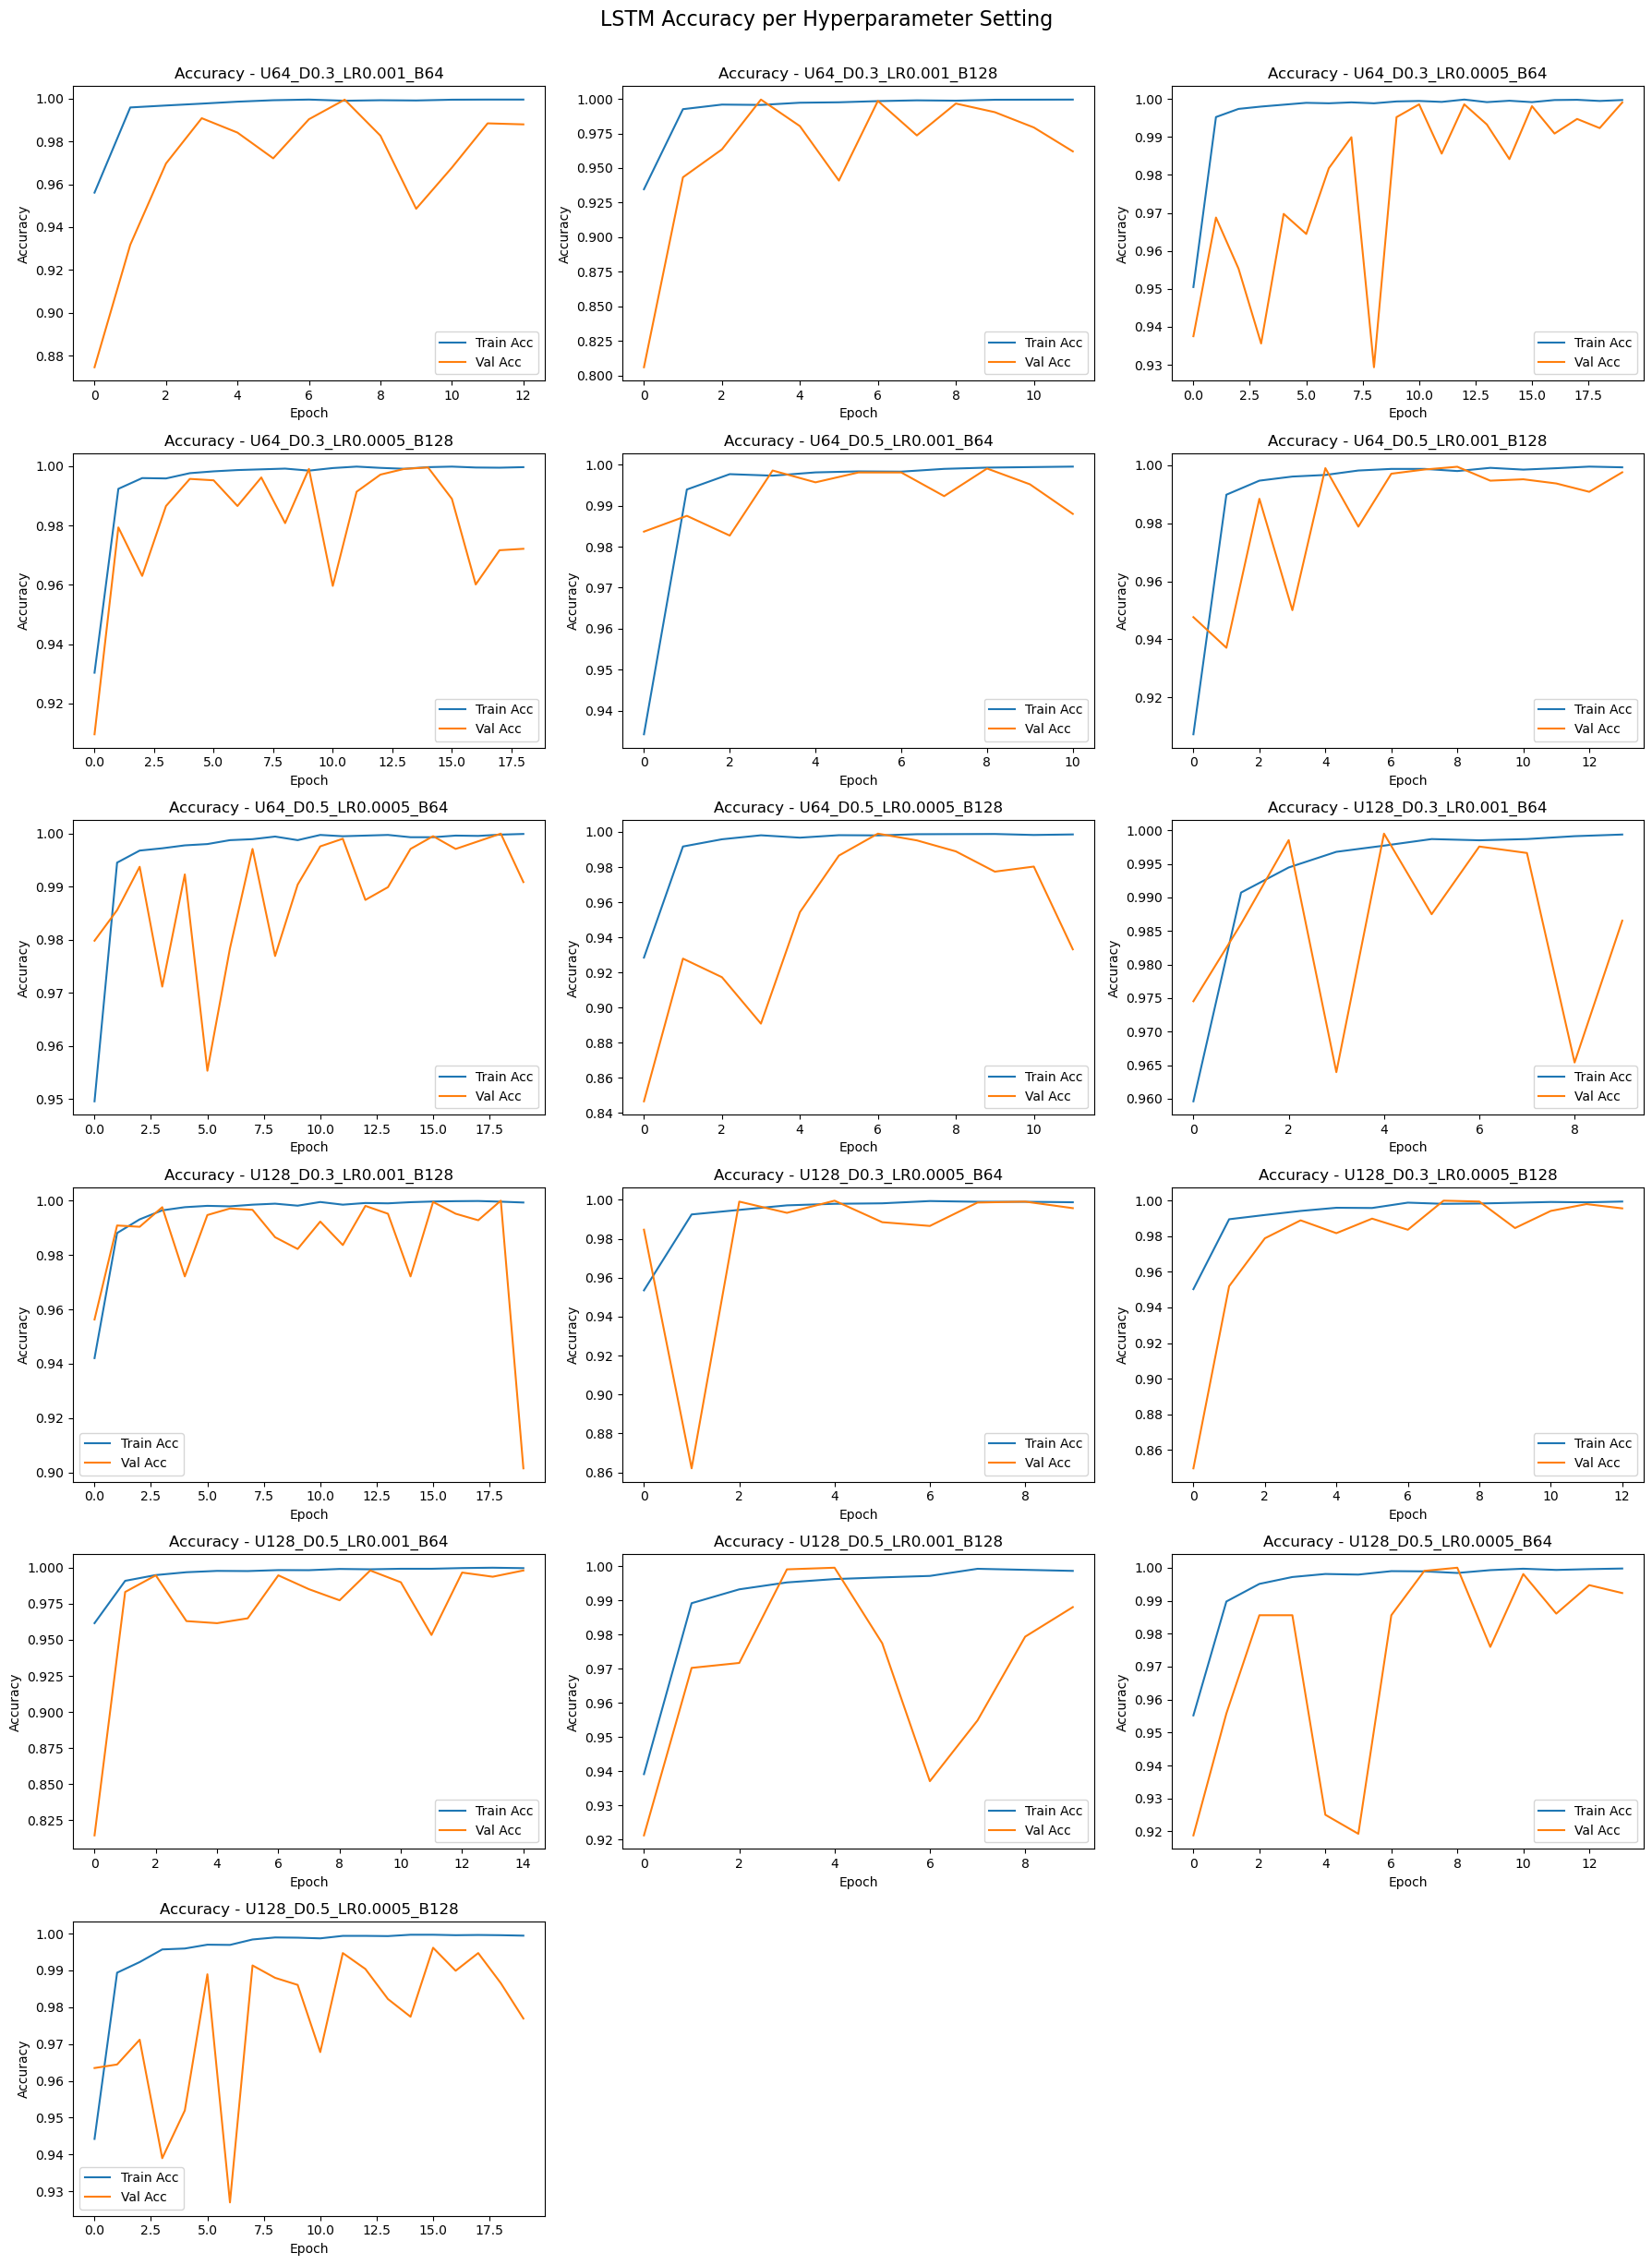

In [35]:
import matplotlib.pyplot as plt

# Plot accuracy in rows of 3
plt.figure(figsize=(18, 4 * ((len(results) + 2) // 3)))  # auto-adjust rows

for i, result in enumerate(results):
    hist = result['history']
    label = f"U{result['units']}_D{result['dropout']}_LR{result['lr']}_B{result['batch_size']}"

    plt.subplot((len(results) + 2) // 3, 3, i + 1)
    plt.plot(hist['accuracy'], label='Train Acc')
    plt.plot(hist['val_accuracy'], label='Val Acc')
    plt.title(f'Accuracy - {label}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

plt.tight_layout()
plt.suptitle('LSTM Accuracy per Hyperparameter Setting', fontsize=16, y=1.02)
plt.show()

#### #### Plot loss curves for different combination of parameters LSTM model trained on

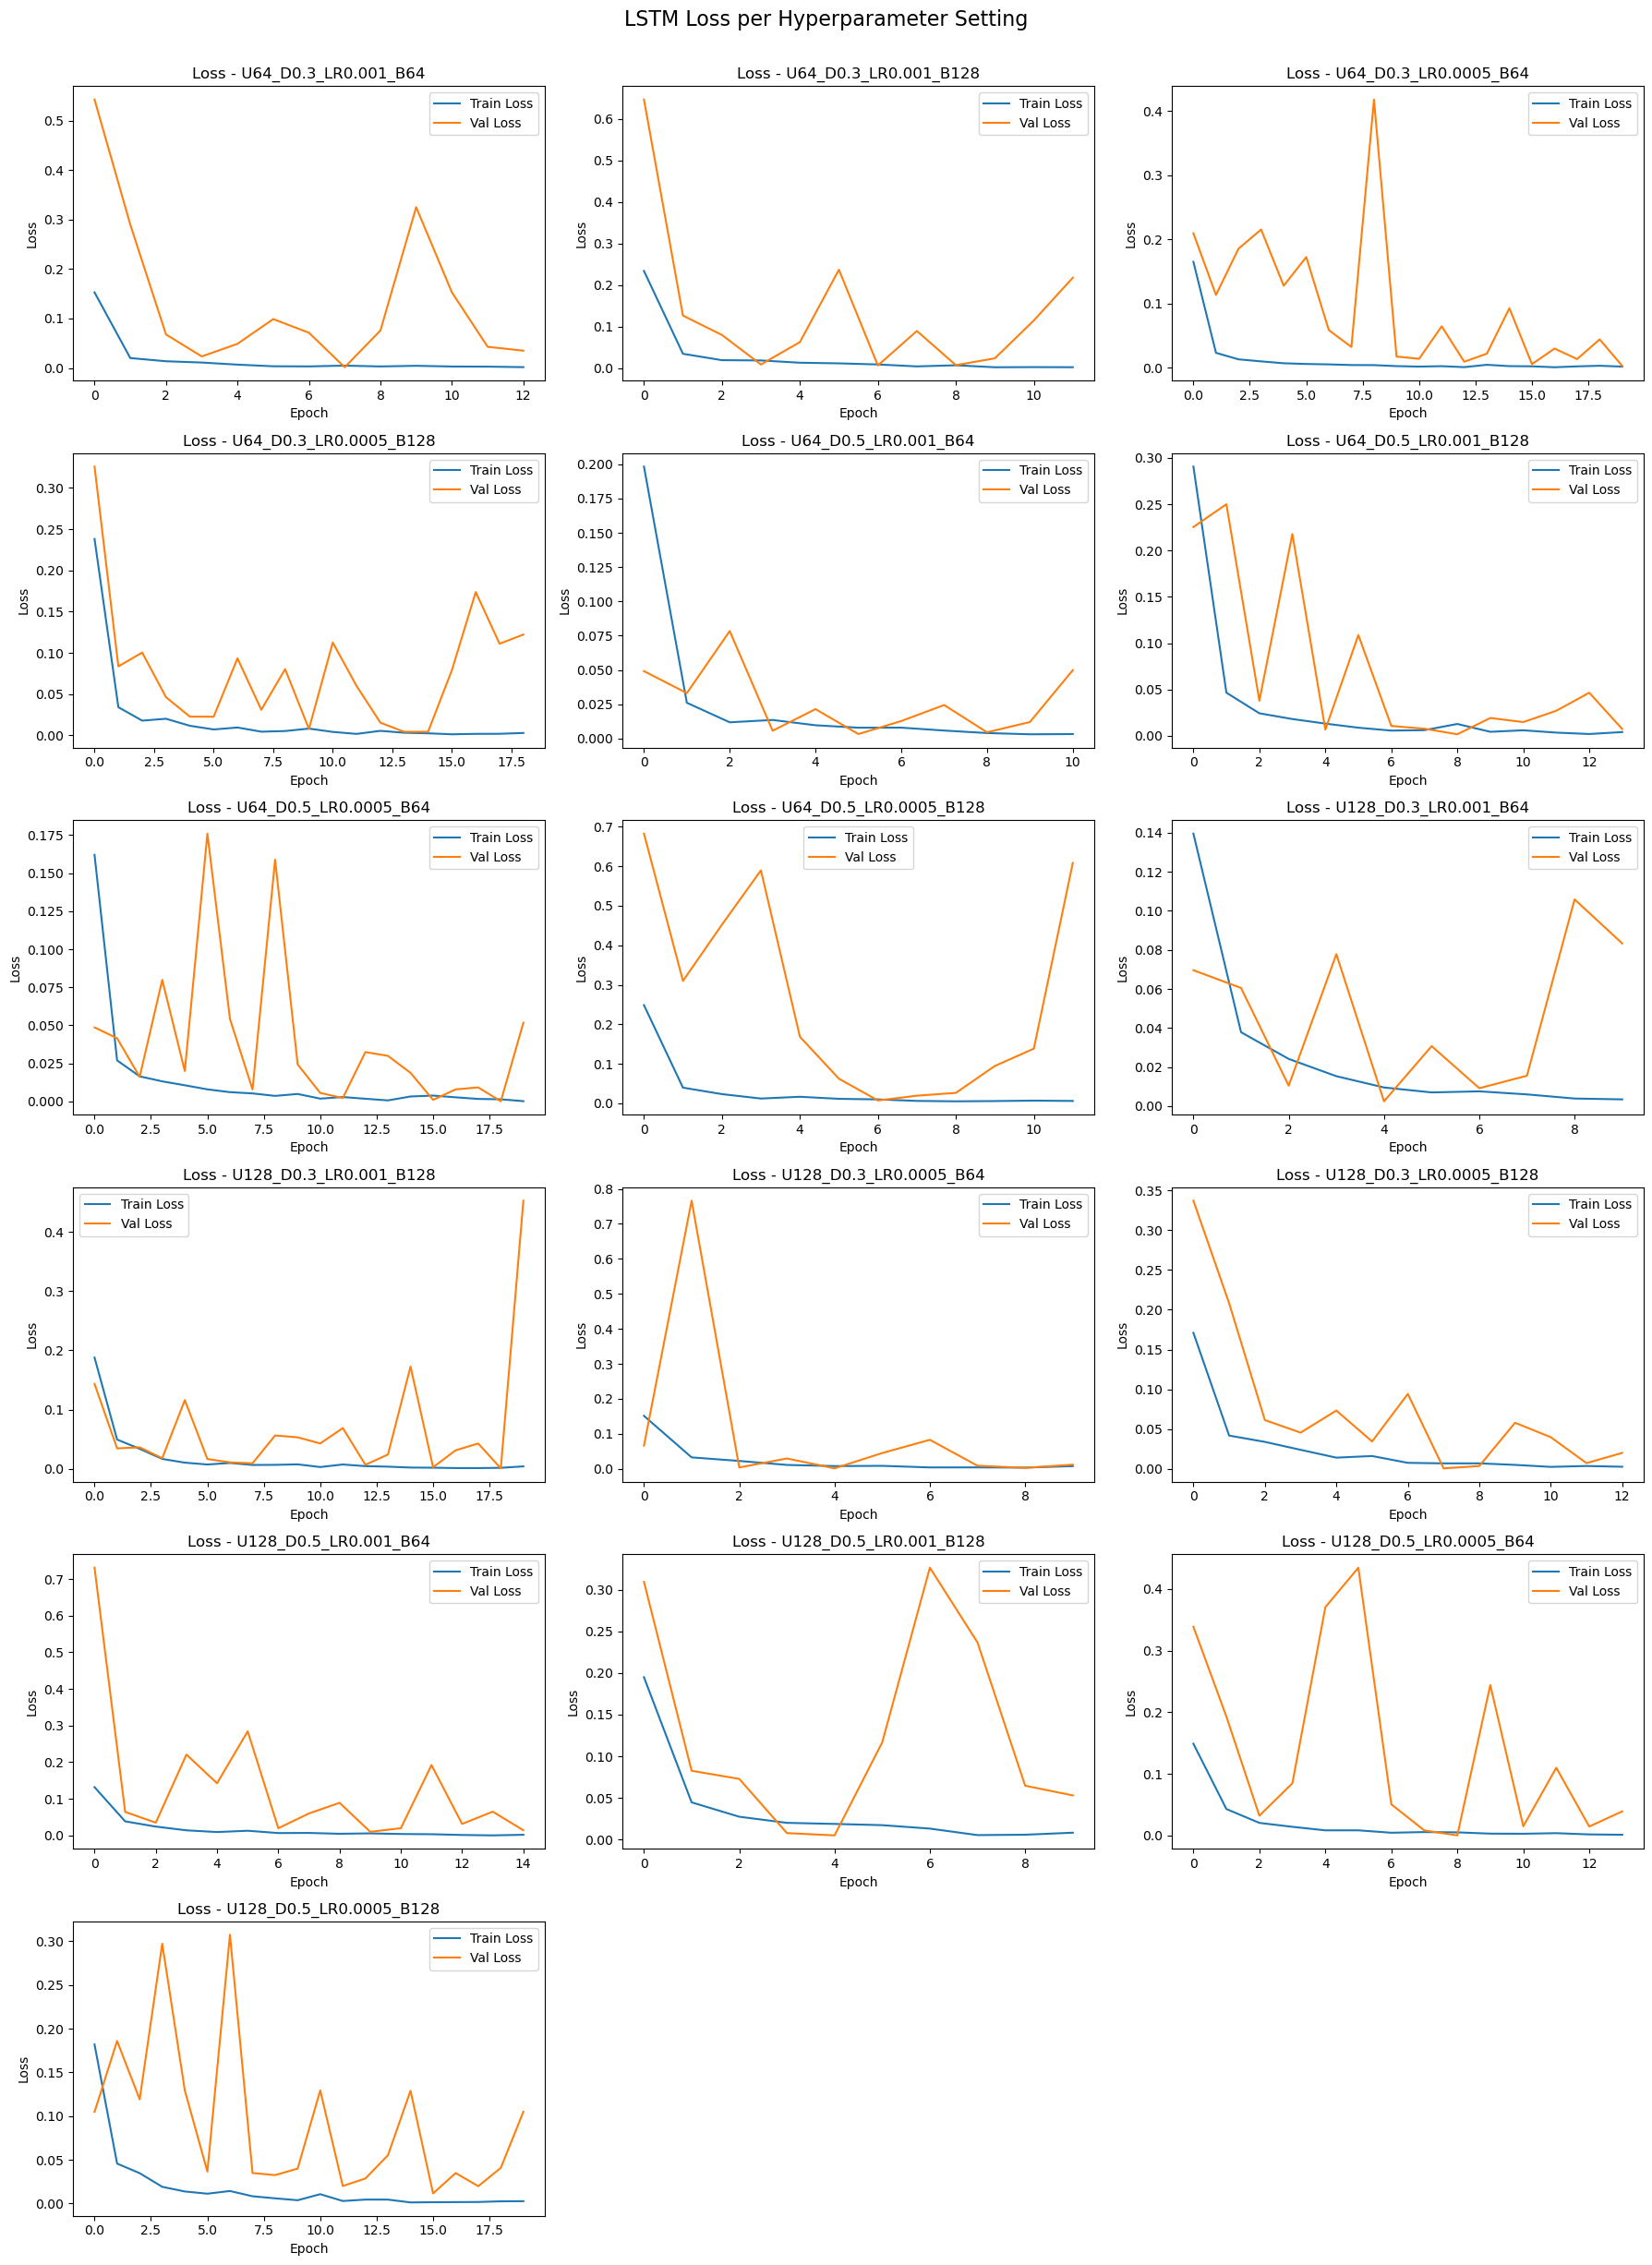

In [37]:
# Plot loss in rows of 3
plt.figure(figsize=(18, 4 * ((len(results) + 2) // 3)))

for i, result in enumerate(results):
    hist = result['history']
    label = f"U{result['units']}_D{result['dropout']}_LR{result['lr']}_B{result['batch_size']}"

    plt.subplot((len(results) + 2) // 3, 3, i + 1)
    plt.plot(hist['loss'], label='Train Loss')
    plt.plot(hist['val_loss'], label='Val Loss')
    plt.title(f'Loss - {label}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

plt.tight_layout()
plt.suptitle('LSTM Loss per Hyperparameter Setting', fontsize=16, y=1.02)
plt.show()

#### Build and train for the plain LSTM model best parameters 

In [39]:
# Build and Train Final Model with Best Params
final_model = build_lstm_model(
    units=128,
    dropout_rate=0.7,
    learning_rate=0.001,
    input_shape=(100, 15),
    num_classes=4
)

final_history = final_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=64,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
    verbose=0
)

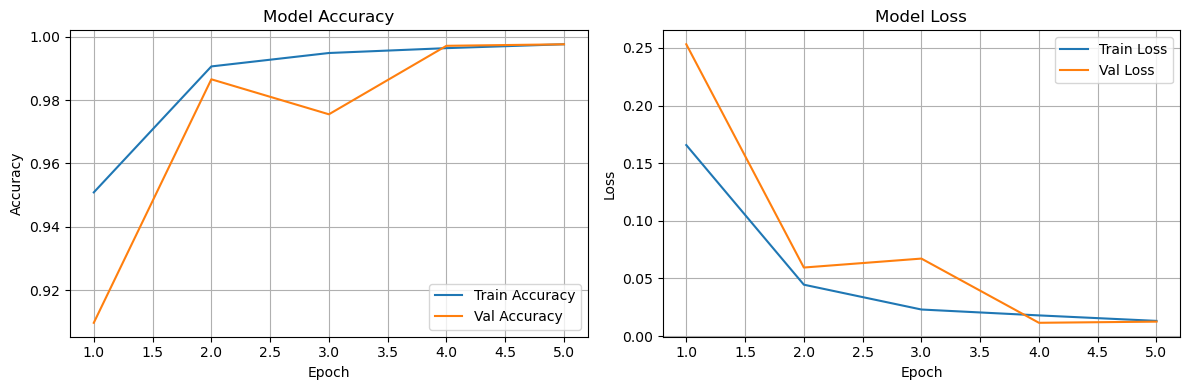

In [40]:
import matplotlib.pyplot as plt

# Extract accuracy and loss from history
acc = final_history.history['accuracy']
val_acc = final_history.history['val_accuracy']
loss = final_history.history['loss']
val_loss = final_history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#### Plain LSTM model evaluation

In [41]:
test_loss, test_acc = final_model.evaluate(X_test, y_test, verbose=1)
print(f"Final Test Accuracy: {test_acc:.4f}")

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8960 - loss: 0.4181
Final Test Accuracy: 0.7953


#### Classification report and confusion matrix to evaluate LSTM model

In [42]:
# Predictions and Classification Report
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get predicted class labels
y_pred_probs = final_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Bach', 'Beethoven', 'Chopin', 'Mozart']))

66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
Classification Report:

              precision    recall  f1-score   support

        Bach       0.99      0.83      0.91       412
   Beethoven       0.67      1.00      0.81       873
      Chopin       0.99      0.30      0.46       406
      Mozart       1.00      0.82      0.90       390

    accuracy                           0.80      2081
   macro avg       0.91      0.74      0.77      2081
weighted avg       0.86      0.80      0.77      2081



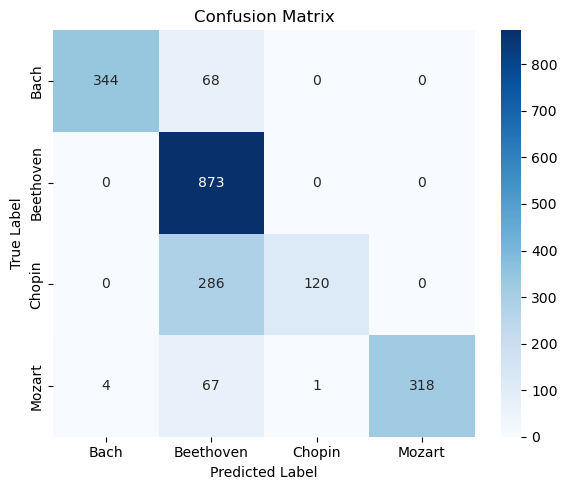

In [43]:
# Confusion matrix plot
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Bach', 'Beethoven', 'Chopin', 'Mozart'],
            yticklabels=['Bach', 'Beethoven', 'Chopin', 'Mozart'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

#### plot precision recall curve for all 4 classes to evaluate LSTM model

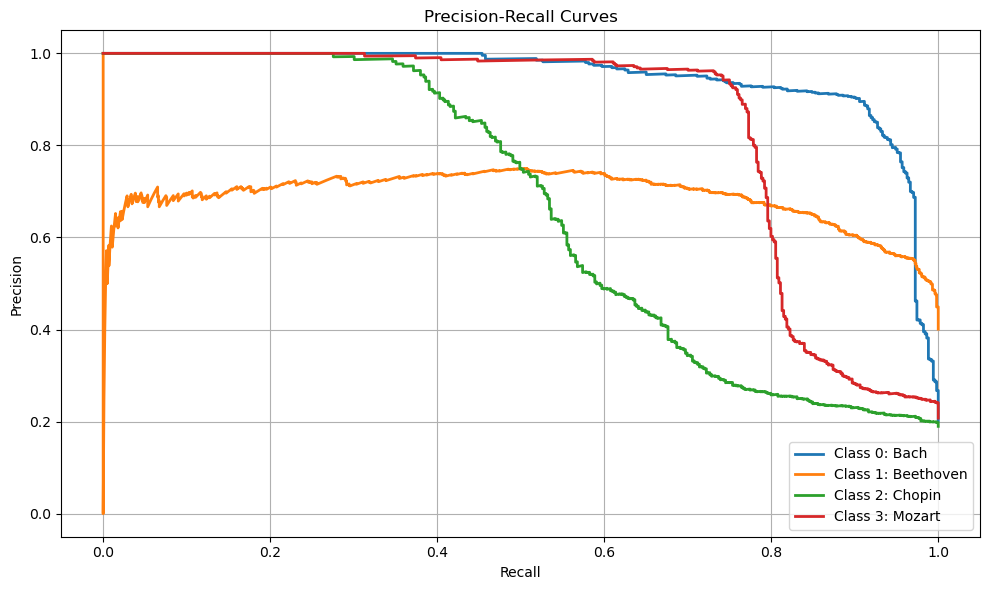

In [34]:
# Precision-recall curve
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize

# Binarize labels for multiclass
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
n_classes = y_test_bin.shape[1]

# Plot precision-recall curves
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_probs[:, i])
    plt.plot(recall, precision, lw=2, label=f'Class {i}: {COMPOSERS[i]}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Implementation of Bidirectional LSTM + attention mechanism to improve the performance of the model

In [ ]:
# import additional libraries required for bidirectional LSTM
from tensorflow.keras.layers import Bidirectional
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# sklearn libraries required
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, roc_curve, auc

In [ ]:
# Define attention layer

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        e = K.tanh(K.dot(inputs, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = inputs * a
        return K.sum(output, axis=1)

In [ ]:
# Define bidirectional LSTM with attention layers

def build_bilstm_attention_model(units=64, dropout_rate=0.5, learning_rate=0.001, input_shape=(100, 15), num_classes=4):
    inputs = Input(shape=input_shape)
    x = Bidirectional(LSTM(units, return_sequences=True))(inputs)
    x = AttentionLayer()(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [47]:
bilstm_att_model = build_bilstm_attention_model(
    units=128,
    dropout_rate=0.5,
    learning_rate=0.001,
    input_shape=(100, 15),
    num_classes=4
)

history_att = bilstm_att_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=0
)

### Model Evaluation on Test set with Bidirectional LSTM + attention

In [49]:
test_loss_bilstm, test_acc_bilstm = bilstm_att_model.evaluate(X_test, y_test, verbose=1)
print(f"BiLSTM Test Accuracy: {test_acc_bilstm:.4f}")

66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9526 - loss: 0.1899
BiLSTM Test Accuracy: 0.8438


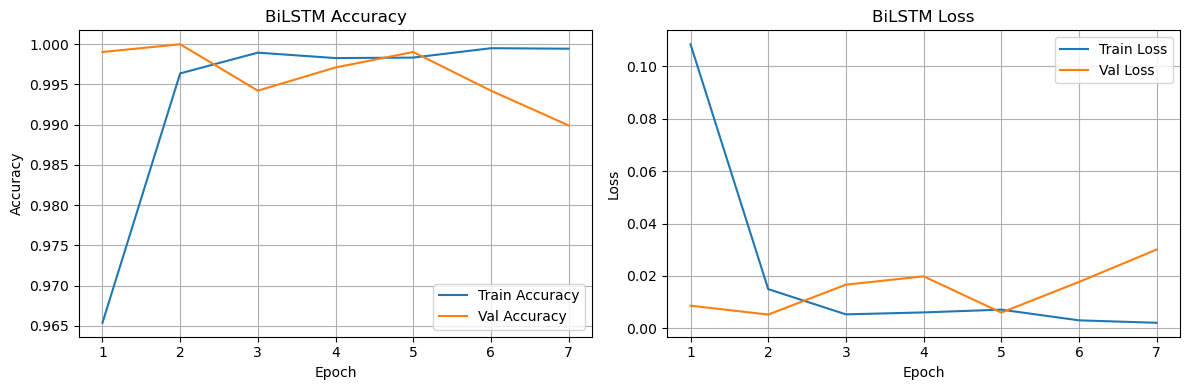

In [51]:
# Extract accuracy and loss from history
acc_bi = history_att.history['accuracy']
val_acc_bi = history_att.history['val_accuracy']
loss_bi = history_att.history['loss']
val_loss_bi = history_att.history['val_loss']
epochs_range_bi = range(1, len(acc_bi) + 1)

plt.figure(figsize=(12, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range_bi, acc_bi, label='Train Accuracy')
plt.plot(epochs_range_bi, val_acc_bi, label='Val Accuracy')
plt.title('BiLSTM Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range_bi, loss_bi, label='Train Loss')
plt.plot(epochs_range_bi, val_loss_bi, label='Val Loss')
plt.title('BiLSTM Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#### Classification report for evaluating bidirectional LSTM + aatention model

66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
Classification Report:

              precision    recall  f1-score   support

        Bach       0.99      0.94      0.96       412
   Beethoven       0.74      1.00      0.85       873
      Chopin       0.95      0.75      0.84       406
      Mozart       1.00      0.50      0.67       390

    accuracy                           0.84      2081
   macro avg       0.92      0.80      0.83      2081
weighted avg       0.88      0.84      0.84      2081



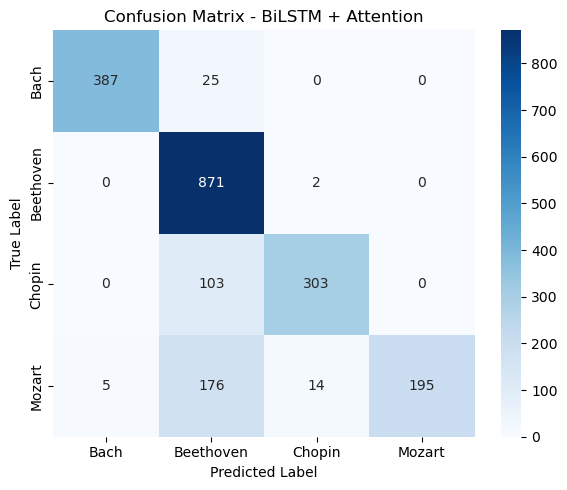

In [ ]:
# Predict class probabilities and convert to labels
y_pred_probs = bilstm_att_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=COMPOSERS))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=COMPOSERS,
            yticklabels=COMPOSERS)
plt.title("Confusion Matrix - BiLSTM + Attention")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [ ]:
# Binarize ground truth
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
n_classes = y_test_bin.shape[1]

#### Plot Precision-recall curves for the best model for visualization

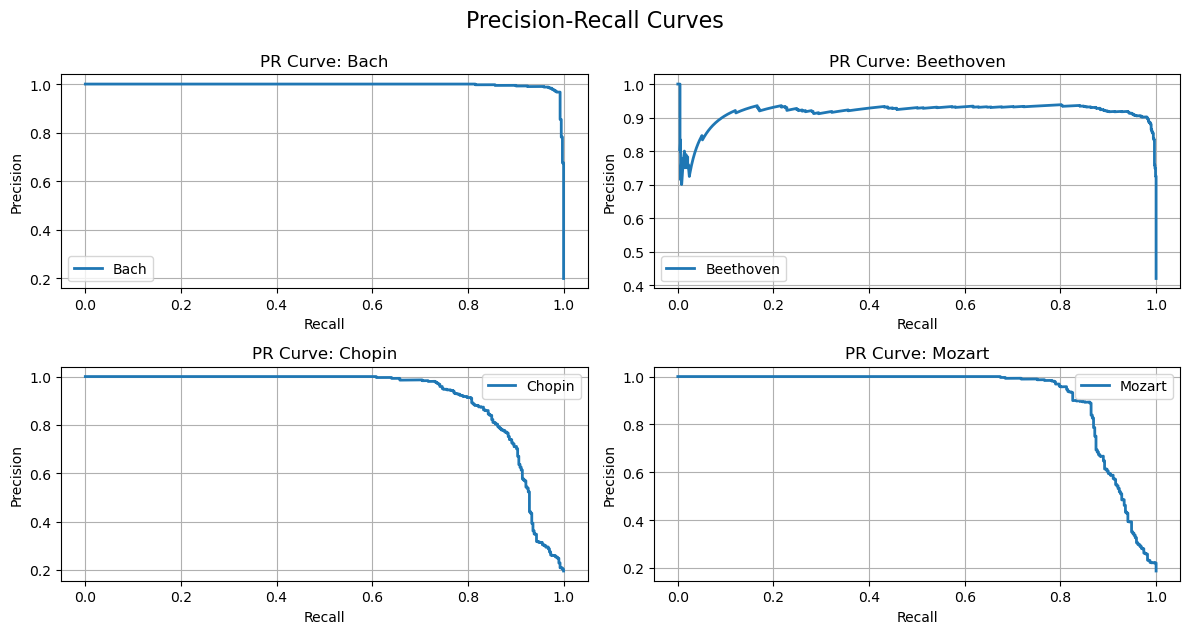

In [56]:
plt.figure(figsize=(12, 6))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_probs[:, i])
    plt.subplot(2, 2, i + 1)
    plt.plot(recall, precision, label=f'{COMPOSERS[i]}', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'PR Curve: {COMPOSERS[i]}')
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.suptitle("Precision-Recall Curves", fontsize=16, y=1.05)
plt.show()

#### Plot ROC-AUC for bidirectional LSTM + attention - best model overall

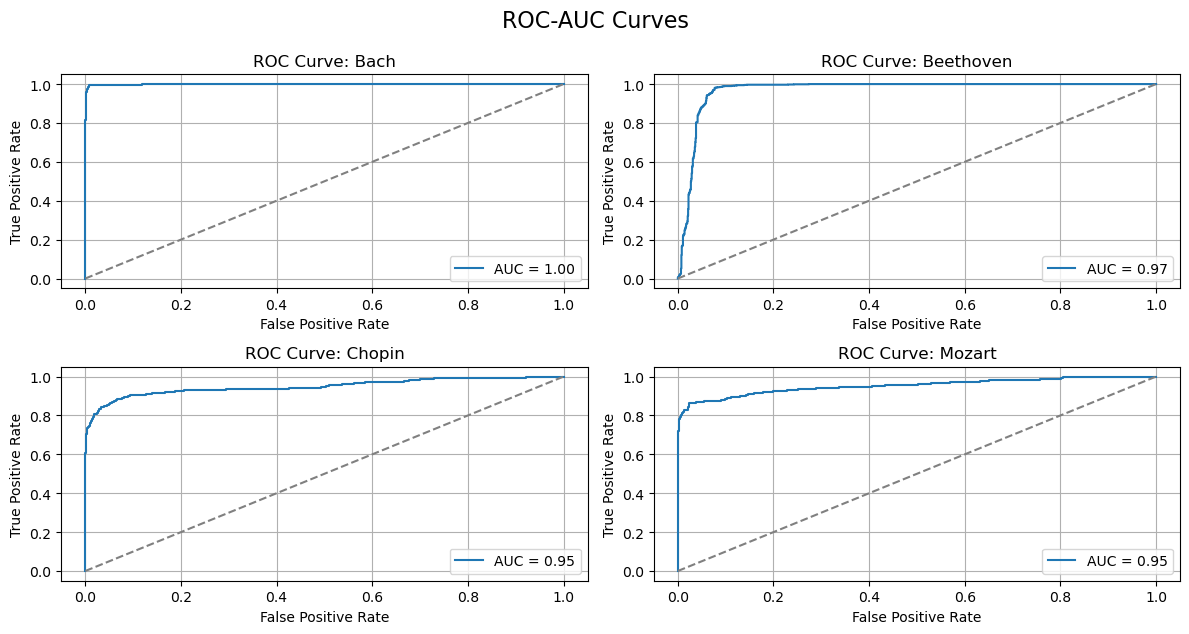

In [57]:
plt.figure(figsize=(12, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.subplot(2, 2, i + 1)
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve: {COMPOSERS[i]}')
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.suptitle("ROC-AUC Curves", fontsize=16, y=1.05)
plt.show()

#### Saving the model for deployment purpose or re-evaluation purpose

In [ ]:
# Save plain LSTM model
final_model.save("lstm_model.keras")
print(" Saved LSTM model as lstm_model.keras")

# Save BiLSTM + Attention model
bilstm_att_model.save("bilstm_attention_model.keras")
print(" Saved BiLSTM + Attention model as bilstm_attention_model.keras")

 Saved LSTM model as lstm_model.keras
 Saved BiLSTM + Attention model as bilstm_attention_model.keras
